# Water distribution network design

## Introduction

A water distribution network is a system of hydraulic elements (pipes, pumps, valves, reservoirs) which are connected together to convey given quantities of water, within prescribed pressures, from sources to consumers. Such a system can be represented as a graph in which the nodes correspond to the sources, consumption points and control elements, and the links correspond to the connecting pipes.

The overall planning process of a water distribution network consists of three phases: layout, design, and operation. Altrough each phase is dependant on the others, they can be formulated and solved as separate problems.

We consider here the design phase. The layout has already been determined during the previous phase, that is, the choice of between which nodes to build a pipe is already fixed. Here, we focus on determining the diameters of the pipes. For simplicity of presentation we consider here simple networks, which do not contain pumps or reservoirs.

Moreover, we deal here with pressurized water networks, where the fluid is transported in pipes with no air contact and thus possibly varying pressure levels. What actually induces a flow between two nodes is explained by a hydrolic head difference in the pipe $a = (i,j)$ between these nodes, where the flow goes from node $i$ to node $j$, which can be modeled using the [Hazen-Williams empirical equation](https://en.wikipedia.org/wiki/Hazen%E2%80%93Williams_equation):
$$h_i-h_j = 10.67 \cdot  \left(\dfrac{q_a}K\right)^{1.852} \cdot L_a \cdot d_a^{-4.87}$$
with 
* $h_i$ and $h_j$ the hydrolic heads at nodes $i$ and $j$, in meters
* $q_a$ is the discharge, in cubic meters per second ($q_a>0$)
* $L_a$ is the pipe length, in meters
* $d_a$ is the pipe diameter, in meters
* $K$ is the Hazen-Williams coefficient, depending on pipe material


<div style="text-align: center;">
    <img src="network_0_layout.png" align=center style="width: 384px; height: auto;">
    <img src="arrow.png" align=center style="width: 50px;"/>
    <img src="network_0_design.png" align=center style="width: 384px; height: auto;">
</div>

## Notebook installation requirements

In [1]:
import subprocess
import sys


def install_requirements():
    try:
        with open("requirements.txt") as f:
            packages = f.read().splitlines()
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", "-r", "requirements.txt"]
        )
        print("All packages have been successfully installed.")
    except Exception as e:
        print(f"An error occurred while installing the packages: {e}")


install_requirements()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 21.3 MB/s eta 0:00:00m eta 0:00:010:00:01
  Attempting uninstall: kaleido
    Found existing installation: kaleido 1.0.0
    Uninstalling kaleido-1.0.0:
      Successfully uninstalled kaleido-1.0.0
All packages have been successfully installed.


Set the type of figures to generate.

In [2]:
fig_type = "png"
# fig_type = ""

## Problem description

**Input**

* A network represented as a directed graph $G = (N, A)$, where nodes stand for sources and junctions, and arcs stand for pipes.
* For each node $i\in N$:
  * $Dem_i$ the demand at node $i$ (positive if junction, negative if source), in cubic meters per second
  * $E_i$ physical elevation of node $i$, in meters
  * $P^{\text{min}}_i$ the minimum pressure at node $i$, in meters 
  * $P^{\text{max}}_i$ the maximum pressure at node $i$, in meters
* For each pipe $a\in A$:
  * $L_a$ the length of pipe $a$, in meters
  * $D^{\text{min}}_a$ the minimum diameter of pipe $a$, in meters
  * $D^{\text{max}}_a$ the maximum diameter of pipe $a$, in meters
  * $V^{\text{max}}_a$ the flow's maximum velocity in pipe $a$, in cubic meters per second
* A discrete set $\{D_1,...,D_L\}$ of $L$ commercially-available diameters for the pipes; for each diameter $D_l$, $l = 1, \dots, L$, a cost of a linear meter of pipe $C_l$
* The Hazen-Williams coefficient $K$, identical for all pipes in this example.

**Problem**:

Choose the diameters of the pipes among the set of available diameters and the water flow values such that:
* Each node demand is satisfied
* Water flows satisfy the hydraulic constraints: Hazen-Williams equation, flow conservation and flow bounds

**Objective**:

Minimize the cost of the pipes (which depends on the selected diameters).

## Mixed-integer nonlinear model

**Variables**

* $q_a\in \mathbb{R}$, $a\in A$, the flow in pipe $a$, in cubic meters per second
* $d_a \in \mathbb{N}$, $D^{\text{min}}_a \le d_a \le D^{\text{max}}_a$, $a\in A$, the diameter of pipe $a$, in meters
* $c_a \in \mathbb{R}$, $a\in A$, the cost of a linear meters of pipe $a$
* $h_i\in [P^{\text{min}}_i+E_i;P^{\text{max}}_i+E_i]$, $i\in N$, the hydrolic head at node $i$, in meters
* $x_{a,l} \in \{0,1\}$, $a\in A$, $l=1,...,L-1$: $x_{a, l} = 1$ iff the diameter of pipe $a$ is at least diameter $D_l$

**Objective**: minimize the cost of the pipes

$$\min \sum_{a \in A} L_a \cdot c_a$$

**Constraints**

- Diameters are in the discrete set $\{D_1,...,D_L\}$:
$$\forall a\in A, \qquad d_a=D_1+\sum_{l=2}^L (D_l-D_{l-1})~x_{a,l-1}$$
$$\forall a\in A, ~ \forall l=1,...,L-2, \qquad x_{a,l}\ge x_{a,l+1}$$

*Note that this incremental modeling allows us to use the branch-and-bounds method more effectively, while branching $d_a \le D_l$ vs $d_a \ge D_{l+1}$ is achived through ordinary 0/1 branching on the single binary variable $x_{a,l}$.*

- Cost of pipes:
$$\forall a\in A, \qquad c_a=C_1+\sum_{l=2}^L (C_l-C_{l-1})~x_{a,l-1}$$

- Flow bounds (dependent on cross-sectional area of pipe):
$$\forall a\in A, \qquad −\frac{\pi}4 d_a^2 \cdot V^{\text{max}}_a \leq q_a \leq \frac{\pi}4 d_a^2 \cdot V^{\text{max}}_a$$

- Flow conservation:
$$\forall i\in N, \qquad \sum_{a\in \delta^-(i)} q_a - \sum_{a\in \delta^+(i)} q_a = Dem_i$$

- Head loss across links (Hazen-Williams equation):
$$\forall a=(i,j)\in A, \qquad h_i-h_j = \text{sign}(q_a) \cdot 10.67 \cdot \left(\dfrac{|q_a|}K\right)^{1.852} \cdot L_a \cdot d_a^{-4.87}$$

To implement this constraint, we linearize the sign and the absolute value.
To do this, we introduce $q_a^+\ge 0$ and $q_a^-\ge 0$ as two new variables such that
$$\forall a\in A, \qquad q_a = q_a^+ - q_a^- \qquad q_a \ge -q_a^- \qquad q_a \ge q_a^+$$
And the Hazen-Williams equation become 
$$\forall a=(i,j)\in A, \qquad (h_i-h_j) \cdot d_a^{4.87} = 10.67 \cdot \dfrac{L_a}{K^{1.852}} \cdot q_a \cdot (q_a^+ + q_a^-)^{0.852}$$

## Input data

Before implementing the model, we first generate some input data.

In [3]:
import numpy as np
import pyomo.environ as pyo


class Node:
    def __init__(self):
        self.demand = None  # demand, cubic meters per second
        self.physical_elevation = None  # physical elevation, meters
        self.p_min = None  # pressure min, meters
        self.p_max = None  # pressure max, meters
        self.type = None  # type of node (source or junction)


class Arc:
    # We fixe the direction of the arc (begin i,end j).
    # If the flow through the arc is positive, it means the flow goes from i to j, otherwise it goes from j to i
    def __init__(self):
        self.begin = None  # node
        self.end = None  # node
        self.length = None  # length, meters
        self.d_min = None  # diameter min, meters
        self.d_max = None  # diameter max, meters
        self.v_max = None  # velocity max, cubic meters per second


class Network:
    def __init__(self, nb_of_nodes, nb_of_pipes):
        self.nb_of_nodes = nb_of_nodes
        self.nb_of_pipes = nb_of_pipes
        # Graph
        self.nodes = [Node() for _ in range(nb_of_nodes)]
        self.pipes = [Arc() for _ in range(nb_of_pipes)]
        # Commercial information
        self.available_diameters = None  # meters
        self.cost_diameters = None
        # Hazen-Williams coefficients
        self.K = None
        # Visualisation data
        self.nodes_position = None
        self.x_range = None
        self.y_range = None
        self.height = None
        self.width = None
        self.name = None
        self.legend_position = None


# Data set 0: "Design of Optimal Water Distribution System" - E. Alperovits and U. Shamir (1977)

nb_of_nodes_0, nb_of_pipes_0 = 7, 8
network_0 = Network(nb_of_nodes_0, nb_of_pipes_0)

# Init nodes
nodes_demand_0 = [-1120, 100, 100, 120, 270, 330, 200]  # m3/h
for j in range(len(nodes_demand_0)):
    nodes_demand_0[j] /= 3600
nodes_physical_elevation_0 = [210, 150, 160, 155, 150, 165, 160]
nodes_p_max_0 = [0, 60, 50, 55, 60, 45, 50]
for i in range(nb_of_nodes_0):
    network_0.nodes[i].demand = nodes_demand_0[i]
    network_0.nodes[i].physical_elevation = nodes_physical_elevation_0[i]
    network_0.nodes[i].p_max = nodes_p_max_0[i]
    if i == 0:
        network_0.nodes[i].p_min = 0
        network_0.nodes[i].type = "source"
    else:
        network_0.nodes[i].p_min = 30
        network_0.nodes[i].type = "junction"

# Init arcs
pipes_begin_0 = [0, 1, 1, 3, 3, 5, 2, 6]
pipes_end_0 = [1, 2, 3, 4, 5, 6, 4, 4]
# pipes_d_min_0 = [12, 6, 10, 3, 10, 8, 6, 6] # inches
# pipes_d_max_0 = [20, 14, 18, 8, 18, 16, 14, 14] # inches
pipes_d_min_0 = [0.3048, 0.1524, 0.254, 0.0762, 0.254, 0.2032, 0.1524, 0.1524]  # meters
pipes_d_max_0 = [
    0.508,
    0.3556,
    0.4572,
    0.2032,
    0.4572,
    0.4064,
    0.3556,
    0.3556,
]  # meters
for i in range(nb_of_pipes_0):
    network_0.pipes[i].begin = pipes_begin_0[i]
    network_0.pipes[i].end = pipes_end_0[i]
    network_0.pipes[i].length = 1000
    network_0.pipes[i].d_min = pipes_d_min_0[i]
    network_0.pipes[i].d_max = pipes_d_max_0[i]
    network_0.pipes[i].v_max = 2

# network_0.available_diameters = [1, 2, 3, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24] # inches
network_0.available_diameters = [
    0.0254,
    0.0508,
    0.0762,
    0.1016,
    0.1524,
    0.2032,
    0.254,
    0.3048,
    0.3556,
    0.4064,
    0.4572,
    0.508,
    0.5588,
    0.6096,
]  # meters
network_0.cost_diameters = [2, 5, 8, 11, 16, 23, 32, 50, 60, 90, 130, 170, 300, 550]
network_0.K = 130

# Init visual data
network_0.nodes_position = [(10, 10), (5, 10), (0, 10), (5, 5), (0, 5), (5, 0), (0, 0)]
network_0.x_range = [-3.5, 12.5]
network_0.y_range = [-1, 12]
network_0.height = 512
network_0.width = 512
network_0.name = "Simple water network"
network_0.legend_position = [(8.5, 8), (8.5, 0)]

Let's visualize this input.

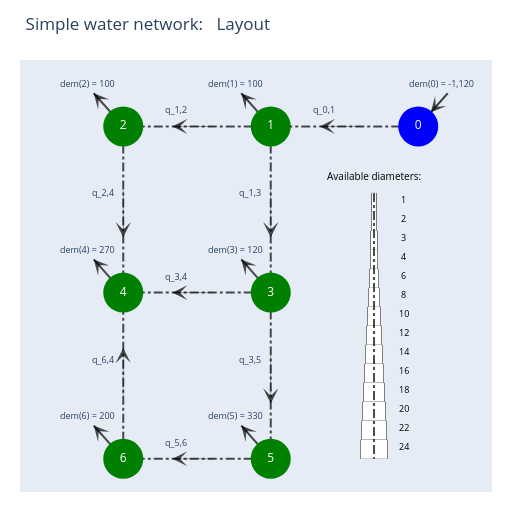

In [4]:
import plotly.graph_objects as go


def create_flow_graph(network):
    fig = go.Figure()
    grey = "rgba(0, 0, 0, 0.7)"

    # Plot pipes
    for i in range(network.nb_of_pipes):
        x0, y0 = network.nodes_position[network.pipes[i].begin]
        x1, y1 = network.nodes_position[network.pipes[i].end]

        fig.add_trace(
            go.Scatter(
                x=[x0, x1],
                y=[y0, y1],
                mode="lines",
                line=dict(color=grey, dash="dashdot", width=2),
                showlegend=False,
            )
        )

        fig.add_annotation(
            x=(2 * x1 + x0) / 3,
            y=(2 * y1 + y0) / 3,
            ax=(3 * x1 + 5 * x0) / 8,
            ay=(3 * y1 + 5 * y0) / 8,
            xref="x",
            yref="y",
            axref="x",
            ayref="y",
            text="",
            showarrow=True,
            arrowhead=3,
            arrowsize=5,
            arrowwidth=0.5,
            arrowcolor=grey,
        )
        fig.add_annotation(
            x=(x1 + x0) / 2 - 0.7,
            y=(y1 + y0) / 2 + 0.5,
            text=f"q_{network.pipes[i].begin},{network.pipes[i].end}",
            showarrow=False,
            arrowhead=3,
            font=dict(size=9),
            align="center",
        )

    # Draw demands
    for i in range(len(network.nodes_position)):
        if network.nodes[i].type == "junction":
            x0, y0 = network.nodes_position[i]
            x1, y1 = x0 - 1, y0 + 1

            fig.add_trace(
                go.Scatter(
                    x=[x0, x1],
                    y=[y0, y1],
                    mode="lines",
                    line=dict(color=grey, width=2),
                    showlegend=False,
                )
            )

            fig.add_annotation(
                x=x1,
                y=y1,
                ax=(3 * x0 + 5 * x1) / 8,
                ay=(3 * y0 + 5 * y1) / 8,
                xref="x",
                yref="y",
                axref="x",
                ayref="y",
                showarrow=True,
                arrowhead=3,
                arrowsize=5,
                arrowwidth=0.5,
                arrowcolor=grey,
            )

        if network.nodes[i].type == "source":
            x0, y0 = network.nodes_position[i]
            x1, y1 = x0 + 1, y0 + 1

            fig.add_trace(
                go.Scatter(
                    x=[x0, x1],
                    y=[y0, y1],
                    mode="lines",
                    line=dict(color=grey, width=2),
                    showlegend=False,
                )
            )

            fig.add_annotation(
                x=(3 * x1 + 5 * x0) / 8 + 0.05,
                y=(3 * y1 + 5 * y0) / 8 + 0.05,
                ax=x1,
                ay=y1,
                xref="x",
                yref="y",
                axref="x",
                ayref="y",
                showarrow=True,
                arrowhead=3,
                arrowsize=5,
                arrowwidth=0.5,
                arrowcolor=grey,
            )
        fig.add_annotation(
            x=x1 - 0.2,
            y=y1 + 0.3,
            text=f"dem({i}) = {network.nodes[i].demand*3600:,.0f}",
            showarrow=False,
            arrowhead=3,
            font=dict(size=9),
            align="center",
        )

    # Plot nodes
    for i in range(len(network.nodes_position)):
        fig.add_trace(
            go.Scatter(
                x=[network.nodes_position[i][0]],
                y=[network.nodes_position[i][1]],
                mode="markers+text",
                text=[i],
                textfont=dict(color="white"),
                marker=dict(
                    size=40,
                    color="blue" if network.nodes[i].type == "source" else "green",
                ),
                showlegend=False,
            )
        )

    # Plot diameters
    x0, y0 = network.legend_position[0]
    x1, y1 = network.legend_position[1]
    hy = (y1 - y0) / len(network.available_diameters)

    fig.add_annotation(
        x=x0,
        y=y0 + 0.5,
        showarrow=False,
        text="Available diameters:",
        font=dict(size=10, color="black"),
    )
    for l in range(len(network.available_diameters)):
        fig.add_trace(
            go.Scatter(
                x=[x0, x0],
                y=[y0 + hy * l, y0 + hy * (l + 1)],
                mode="lines",
                line=dict(
                    color="black", width=(network.available_diameters[l] / 0.0254 + 4)
                ),
                showlegend=False,
            )
        )
        fig.add_trace(
            go.Scatter(
                x=[x0, x0],
                y=[y0 + hy * l, y0 + hy * (l + 1)],
                mode="lines",
                line=dict(
                    color="rgba(255, 255, 255, 1)",
                    width=network.available_diameters[l] / 0.0254 + 3,
                ),
                showlegend=False,
            )
        )
        # annotation diameter
        fig.add_annotation(
            x=x0 + 1,
            y=y0 + hy * l - 0.2,
            showarrow=False,
            text=f"{network.available_diameters[l] / 0.0254:,.0f}",
            font=dict(size=9, color="black"),
            align="right",
        )
    # line
    fig.add_trace(
        go.Scatter(
            x=[x0, x0],
            y=[y0, y1],
            mode="lines",
            line=dict(color=grey, dash="dashdot", width=2),
            showlegend=False,
        )
    )

    fig.update_layout(
        title=f"{network.name}:   Layout",
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        showlegend=False,
    )
    fig.update_layout(
        xaxis=dict(range=network.x_range),
        yaxis=dict(range=network.y_range),
        height=network.height,
        width=network.width,
        margin=dict(l=20, r=20, t=60, b=20),
    )
    fig.show(fig_type)


create_flow_graph(network_0)

## Model implementation

Now, let's implement the model using Pyomo.

In [5]:
def create_model(network):  # Create the optimization model
    model = pyo.ConcreteModel()

    ##############
    # Pyomo sets #
    ##############

    model.NN = pyo.RangeSet(0, network.nb_of_nodes - 1)

    model.NP = pyo.RangeSet(0, network.nb_of_pipes - 1)

    model.ND = pyo.RangeSet(0, len(network.available_diameters) - 1)

    ####################
    # Create variables #
    ####################

    # Flow in pipes
    model.q = pyo.Var(model.NP)
    model.q_plus = pyo.Var(model.NP, within=pyo.NonNegativeReals)
    model.q_minus = pyo.Var(model.NP, within=pyo.NonNegativeReals)

    # Diameter of pipes
    def d_bounds_rule(model, a):
        return (network.pipes[a].d_min, network.pipes[a].d_max)

    model.d = pyo.Var(model.NP, bounds=d_bounds_rule)

    # Hydrolic head
    def h_bounds_rule(model, i):
        return (
            network.nodes[i].p_min + network.nodes[i].physical_elevation,
            network.nodes[i].p_max + network.nodes[i].physical_elevation,
        )

    model.h = pyo.Var(model.NN, bounds=h_bounds_rule)

    # Diameter increment
    model.x = pyo.Var(model.NP, model.ND, within=pyo.Binary)

    # Cost of pipes
    model.c = pyo.Var(model.NP)

    #############
    # Objective #
    #############

    # Minimize the cost of the pipes
    def objective_rule(model):
        return sum(model.c[a] * network.pipes[a].length for a in model.NP)

    model.obj = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

    ###############
    # Constraints #
    ###############

    # Diameters are in the discrete set {d_1,...,d_n}
    def discretize_diameter_rule(model, a):
        return model.d[a] == network.available_diameters[0] * model.x[a, 0] + sum(
            (network.available_diameters[l] - network.available_diameters[l - 1])
            * model.x[a, l]
            for l in range(1, len(network.available_diameters))
        )

    model.discretize_diameter = pyo.Constraint(model.NP, rule=discretize_diameter_rule)

    def x_rule(model, a, l):
        if l <= len(network.available_diameters) - 2:
            return model.x[a, l] >= model.x[a, l + 1]
        return pyo.Constraint.Skip

    model.x_rule = pyo.Constraint(model.NP, model.ND, rule=x_rule)

    # Cost of pipes
    def pipe_cost_rule(model, a):
        return model.c[a] == network.cost_diameters[0] * model.x[a, 0] + sum(
            (network.cost_diameters[l] - network.cost_diameters[l - 1]) * model.x[a, l]
            for l in range(1, len(network.available_diameters))
        )

    model.pipe_cost = pyo.Constraint(model.NP, rule=pipe_cost_rule)

    # Flow bounds
    def flow_lb_rule(model, a):
        return -np.pi / 4 * model.d[a] ** 2 * network.pipes[a].v_max <= model.q[a]

    model.flow_lb = pyo.Constraint(model.NP, rule=flow_lb_rule)

    def flow_ub_rule(model, a):
        return model.q[a] <= np.pi / 4 * model.d[a] ** 2 * network.pipes[a].v_max

    model.flow_ub = pyo.Constraint(model.NP, rule=flow_ub_rule)

    # Flow conservation
    def flow_conservation_rule(model, i):
        return (
            sum(model.q[a] for a in model.NP if (network.pipes[a].end == i))
            - sum(model.q[a] for a in model.NP if (network.pipes[a].begin == i))
            == network.nodes[i].demand
        )

    model.flow_conservation = pyo.Constraint(model.NN, rule=flow_conservation_rule)

    # Linearize abs(model.q[a])
    def def_q(model, a):
        return model.q[a] == model.q_plus[a] - model.q_minus[a]

    model.def_q = pyo.Constraint(model.NP, rule=def_q)

    def def_q_minus(model, a):
        return model.q[a] >= -model.q_minus[a]

    model.def_q_minus = pyo.Constraint(model.NP, rule=def_q_minus)

    def def_q_plus(model, a):
        return model.q[a] >= model.q_plus[a]

    model.def_q_plus = pyo.Constraint(model.NP, rule=def_q_plus)

    # Head loss
    def head_loss_rule(model, a):
        return (
            model.d[a] ** (4.87)
            * (model.h[network.pipes[a].begin] - model.h[network.pipes[a].end])
            == 10.67
            * model.q[a]
            * (model.q_plus[a] + model.q_minus[a]) ** (0.852)
            / network.K ** (1.852)
            * network.pipes[a].length
        )

    model.head_loss = pyo.Constraint(model.NP, rule=head_loss_rule)

    return model

Let's solve the model with Knitro.

In [6]:
model_0 = create_model(network_0)
solver = pyo.SolverFactory("knitroampl")
solver.options["mip_multistart"] = 1
solver.options["mip_maxnodes"] = 2048
result = solver.solve(model_0, tee=True)

Artelys Knitro 15.0.0: mip_multistart=1
mip_maxnodes=2048

          Commercial License
         Artelys Knitro 15.0.0

No start point provided -- Knitro computing one.

concurrent_evals         0
datacheck                0
feastol                  1e-06
feastol_abs              1e-06
findiff_numthreads       1
hessian_no_f             1
hessopt                  1
mip_maxnodes             2048
mip_multistart           1
opttol                   1e-06
opttol_abs               0.001
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_root_nlpalg from AUTO to 1.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro changing mip_cut_flowcover from AUTO to 2.
Knitro changing

### Output visualization

Let's visualize the solution found by Knitro.


Solution:
-------------------
Objective: $448,000

Pipe 0:   d = 18,   q = 1,120.000
Pipe 1:   d = 12,   q = 350.810
Pipe 2:   d = 16,   q = 669.190
Pipe 3:   d = 3,   q = 11.362
Pipe 4:   d = 16,   q = 537.828
Pipe 5:   d = 10,   q = 207.828
Pipe 6:   d = 10,   q = 250.810
Pipe 7:   d = 6,   q = 7.828

Node 0:   h = 210.000
Node 1:   h = 203.250
Node 2:   h = 197.585
Node 3:   h = 198.635
Node 4:   h = 190.191
Node 5:   h = 195.556
Node 6:   h = 190.335



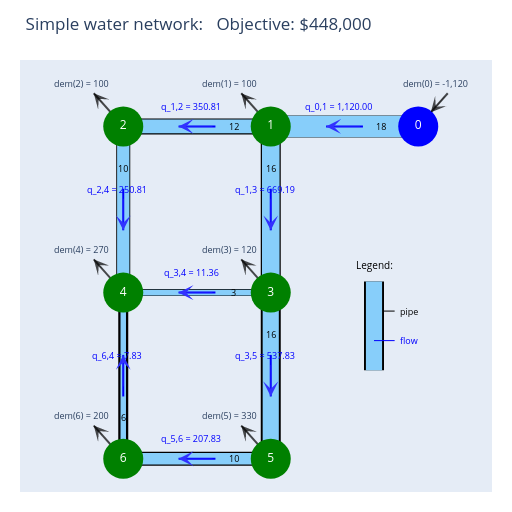

In [7]:
def create_flow_graph_with_model(model, network):
    fig = go.Figure()
    grey = "rgba(0, 0, 0, 0.7)"

    # Plot pipes
    for a in range(network.nb_of_pipes):
        x0, y0 = network.nodes_position[network.pipes[a].begin]
        x1, y1 = network.nodes_position[network.pipes[a].end]
        # pipe
        fig.add_trace(
            go.Scatter(
                x=[x0, x1],
                y=[y0, y1],
                mode="lines",
                line=dict(color="black", width=model.d[a].value / 0.0254 + 4),
                showlegend=False,
            )
        )
        # annotation diameter
        fig.add_annotation(
            x=(x1 + 3 * x0) / 4,
            y=(y1 + 3 * y0) / 4,
            showarrow=False,
            text=f"{model.d[a].value/0.0254:,.0f}",
            font=dict(size=9, color="black"),
        )
        # flow
        fig.add_trace(
            go.Scatter(
                x=[x0, x1],
                y=[y0, y1],
                mode="lines",
                line=dict(
                    color="rgba(135, 206, 250, 1)",
                    width=np.sqrt(
                        4
                        / (np.pi * network.pipes[a].v_max)
                        * model.q[a].value
                        / (0.0254**2)
                    )
                    + 4,
                ),
                showlegend=False,
            )
        )
        # annotation flow
        fig.add_trace(
            go.Scatter(
                x=[(3 * x1 + 5 * x0) / 8, (5 * x1 + 3 * x0) / 8],
                y=[(3 * y1 + 5 * y0) / 8, (5 * y1 + 3 * y0) / 8],
                mode="lines",
                line=dict(width=2, color="blue"),
            )
        )
        fig.add_annotation(
            x=(5 * x1 + 3 * x0) / 8,
            y=(5 * y1 + 3 * y0) / 8,
            ax=(3 * x1 + 5 * x0) / 8,
            ay=(3 * y1 + 5 * y0) / 8,
            xref="x",
            yref="y",
            axref="x",
            ayref="y",
            showarrow=True,
            arrowhead=3,
            arrowsize=5,
            arrowwidth=0.5,
            arrowcolor="rgba(50, 50, 255, 1)",
        )
        fig.add_annotation(
            x=(x1 + x0) / 2 - 0.2,
            y=(y1 + y0) / 2 + 0.6,
            showarrow=False,
            text=f"q_{network.pipes[a].begin},{network.pipes[a].end} = {model.q[a].value*3600:,.2f}",
            font=dict(size=9, color="rgba(0, 0, 255, 1)"),
        )

    # Draw demands
    for i in range(len(network.nodes_position)):
        if network.nodes[i].type == "junction":
            x0, y0 = network.nodes_position[i]
            x1, y1 = x0 - 1, y0 + 1
            # line
            fig.add_trace(
                go.Scatter(
                    x=[x0, x1],
                    y=[y0, y1],
                    mode="lines",
                    line=dict(color=grey, width=2),
                    showlegend=False,
                )
            )
            # annotation arrow
            fig.add_annotation(
                x=x1,
                y=y1,
                ax=(3 * x0 + 5 * x1) / 8,
                ay=(3 * y0 + 5 * y1) / 8,
                xref="x",
                yref="y",
                axref="x",
                ayref="y",
                showarrow=True,
                arrowhead=3,
                arrowsize=5,
                arrowwidth=0.5,
                arrowcolor=grey,
            )

        if network.nodes[i].type == "source":
            x0, y0 = network.nodes_position[i]
            x1, y1 = x0 + 1, y0 + 1
            # line
            fig.add_trace(
                go.Scatter(
                    x=[x0, x1],
                    y=[y0, y1],
                    mode="lines",
                    line=dict(color=grey, width=2),
                    showlegend=False,
                )
            )
            # annotation arrow
            fig.add_annotation(
                x=(3 * x1 + 5 * x0) / 8 + 0.05,
                y=(3 * y1 + 5 * y0) / 8 + 0.05,
                ax=x1,
                ay=y1,
                xref="x",
                yref="y",
                axref="x",
                ayref="y",
                showarrow=True,
                arrowhead=3,
                arrowsize=5,
                arrowwidth=0.5,
                arrowcolor=grey,
            )
        # annotation demand
        fig.add_annotation(
            x=x1 - 0.4,
            y=y1 + 0.3,
            text=f"dem({i}) = {network.nodes[i].demand*3600:,.0f}",
            showarrow=False,
            arrowhead=3,
            font=dict(size=9),
            align="center",
        )

    # Plot nodes
    for i in range(len(network.nodes_position)):
        fig.add_trace(
            go.Scatter(
                x=[network.nodes_position[i][0]],
                y=[network.nodes_position[i][1]],
                mode="markers+text",
                text=[i],
                textfont=dict(color="white"),
                marker=dict(
                    size=40,
                    color="blue" if network.nodes[i].type == "source" else "green",
                ),
                showlegend=False,
            )
        )

    # Plot legend
    x0, y0 = network.legend_position[0]
    x1, y1 = network.legend_position[1]
    hy = (y1 - y0) / 3

    fig.add_annotation(
        x=x0,
        y=y0 + hy + 0.5,
        showarrow=False,
        text="Legend:",
        font=dict(size=10, color="black"),
    )
    # pipe
    fig.add_trace(
        go.Scatter(
            x=[x0, x0],
            y=[y0 + hy, y0 + 2 * hy],
            mode="lines",
            line=dict(color="black", width=model.d[4].value / 0.0254 + 4),
            showlegend=False,
        )
    )
    fig.add_trace(
        go.Scatter(
            x=[x0, x0 + 0.7],
            y=[y0 + 4 / 3 * hy, y0 + 4 / 3 * hy],
            mode="lines",
            line=dict(color="black", width=1),
            showlegend=False,
        )
    )
    fig.add_annotation(
        x=x0 + 1.2,
        y=y0 + 4 / 3 * hy,
        showarrow=False,
        text="pipe",
        font=dict(size=9, color="black"),
        align="right",
    )

    # flow
    fig.add_trace(
        go.Scatter(
            x=[x0, x1],
            y=[y0 + hy, y0 + 2 * hy],
            mode="lines",
            line=dict(
                color="rgba(135, 206, 250, 1)",
                width=np.sqrt(
                    4
                    / (np.pi * network.pipes[4].v_max)
                    * model.q[4].value
                    / (0.0254**2)
                )
                + 4,
            ),
            showlegend=False,
        )
    )
    fig.add_trace(
        go.Scatter(
            x=[x0, x0 + 0.7],
            y=[y0 + 5 / 3 * hy, y0 + 5 / 3 * hy],
            mode="lines",
            line=dict(color="blue", width=1),
            showlegend=False,
        )
    )
    fig.add_annotation(
        x=x0 + 1.2,
        y=y0 + 5 / 3 * hy,
        showarrow=False,
        text="flow",
        font=dict(size=9, color="blue"),
        align="right",
    )

    fig.update_layout(
        title=f"{network.name}:   Objective: ${model.obj():,.0f}",
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        showlegend=False,
    )
    fig.update_layout(
        xaxis=dict(range=network.x_range),
        yaxis=dict(range=network.y_range),
        height=network.height,
        width=network.width,
        margin=dict(l=20, r=20, t=60, b=20),
    )
    fig.show(fig_type)


def print_results(model, network):
    print()
    print(f"Solution:")
    print("-------------------")
    print(f"Objective: ${model.obj():,.0f}\n")
    for a in range(network.nb_of_pipes):
        print(
            f"Pipe {a}:   d = {model.d[a]()/0.0254:,.0f},   q = {model.q[a]()*3600:,.3f}"
        )
    print()
    for i in range(network.nb_of_nodes):
        print(f"Node {i}:   h = {model.h[i]():,.3f}")
    print()


print_results(model_0, network_0)
create_flow_graph_with_model(model_0, network_0)

## Larger example

Now let's try on a larger network.

In [8]:
# Data set 1: Hanoi: "A two-phase decomposition method for optimal design of looped water distribution networks" - Okitsugu Fujiwara, Do Ba Khang (1990)
# https://raw.githubusercontent.com/OpenWaterAnalytics/EPyT/main/epyt/networks/asce-tf-wdst/Hanoi.inp

nb_of_nodes_1, nb_of_pipes_1 = 32, 34
network_1 = Network(nb_of_nodes_1, nb_of_pipes_1)

# Init nodes
nodes_demand_1 = [
    -5538.9,
    247.22,
    236.11,
    36.11,
    201.39,
    279.17,
    375,
    152.78,
    145.83,
    145.83,
    138.89,
    155.56,
    261.11,
    170.83,
    77.78,
    86.11,
    240.28,
    373.61,
    16.67,
    354.17,
    258.33,
    134.72,
    290.28,
    227.78,
    47.22,
    250,
    102.78,
    80.56,
    100,
    100,
    29.17,
    223.61,
]
for j in range(len(nodes_demand_1)):
    nodes_demand_1[j] /= 3600
for i in range(nb_of_nodes_1):
    network_1.nodes[i].demand = nodes_demand_1[i]
    network_1.nodes[i].physical_elevation = 0
    network_1.nodes[i].p_max = 100
    if i == 0:
        network_1.nodes[i].p_min = 100
        network_1.nodes[i].type = "source"
    else:
        network_1.nodes[i].p_min = 30
        network_1.nodes[i].type = "junction"

# Init arcs
pipes_begin_1 = [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    9,
    13,
    14,
    16,
    17,
    18,
    2,
    2,
    19,
    20,
    19,
    22,
    23,
    25,
    26,
    15,
    22,
    27,
    28,
    29,
    31,
    24,
]
pipes_end_1 = [
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
    30,
    31,
]
pipes_length_1 = [
    100,
    1350,
    900,
    1150,
    1450,
    450,
    850,
    850,
    800,
    950,
    1200,
    3500,
    800,
    500,
    550,
    2730,
    1750,
    800,
    400,
    2200,
    1500,
    500,
    2650,
    1230,
    1300,
    850,
    300,
    750,
    1500,
    2000,
    1600,
    150,
    860,
    950,
]
pipes_v_max_1 = [
    7.0,
    7.0,
    3.0,
    3.0,
    2.5,
    2.5,
    2.0,
    2.0,
    2.0,
    2.0,
    2.0,
    2.0,
    2.0,
    2.0,
    2.0,
    2.0,
    2.0,
    3.5,
    3.5,
    3.0,
    2.0,
    2.0,
    2.0,
    3.0,
    2.0,
    2.0,
    2.0,
    2.0,
    2.0,
    2.0,
    2.0,
    2.0,
    2.0,
    2.0,
]
for i in range(nb_of_pipes_1):
    network_1.pipes[i].begin = pipes_begin_1[i]
    network_1.pipes[i].end = pipes_end_1[i]
    network_1.pipes[i].length = pipes_length_1[i]
    network_1.pipes[i].d_min = 0.3048
    network_1.pipes[i].d_max = 1.016
    network_1.pipes[i].v_max = pipes_v_max_1[i]

# network_1.available_diameters = [12,16,20,24,30,40] # inches
network_1.available_diameters = [0.3048, 0.4064, 0.508, 0.6096, 0.762, 1.016]  # meters
network_1.cost_diameters = [45.73, 70.40, 98.39, 129.33, 180.75, 278.28]
network_1.K = 130

# Init visual data
network_1.nodes_position = [
    (12.67525, 0.0),
    (12.67525, 3.91355),
    (12.5584, 7.41825),
    (16.76405, 7.41825),
    (19.8014, 7.41825),
    (22.72195, 7.41825),
    (22.72195, 10.57245),
    (22.72195, 14.0771),
    (22.72195, 17.52335),
    (20.3855, 17.52335),
    (20.3855, 20.3271),
    (20.3855, 22.3715),
    (17.1729, 22.3715),
    (17.93225, 17.52335),
    (14.83645, 17.52335),
    (12.5, 17.52335),
    (12.5, 15.24535),
    (12.5584, 13.25935),
    (12.5584, 10.2804),
    (9.17055, 7.41825),
    (9.17055, 4.0888),
    (9.17055, 0.5257),
    (6.3084, 7.41825),
    (6.3084, 13.4346),
    (6.1916, 17.52335),
    (8.46965, 17.52335),
    (10.51405, 17.52335),
    (3.44625, 7.41825),
    (0.0, 7.59345),
    (0.0, 12.09115),
    (0.0, 17.52335),
    (3.44625, 17.52335),
]
network_1.x_range = [-2.5, 24]
network_1.y_range = [-1, 24]
network_1.height = 1024
network_1.width = 1024
network_1.name = "Hanoi water network"
network_1.legend_position = [(20, 5.5), (20, 0)]

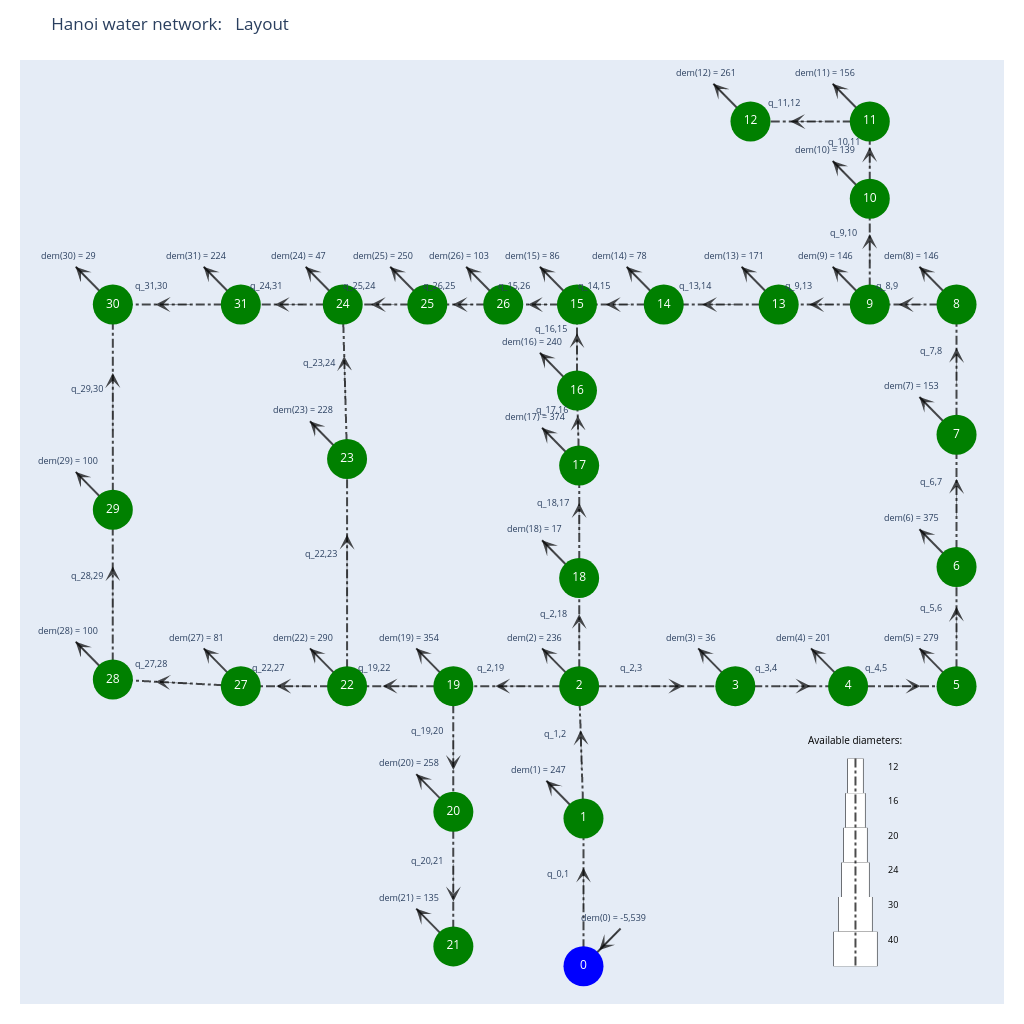

In [9]:
create_flow_graph(network_1)

In [10]:
model_1 = create_model(network_1)
result = solver.solve(model_1, tee=True)

Artelys Knitro 15.0.0: mip_multistart=1
mip_maxnodes=2048

          Commercial License
         Artelys Knitro 15.0.0

No start point provided -- Knitro computing one.

concurrent_evals         0
datacheck                0
feastol                  1e-06
feastol_abs              1e-06
findiff_numthreads       1
hessian_no_f             1
hessopt                  1
mip_maxnodes             2048
mip_multistart           1
opttol                   1e-06
opttol_abs               0.001
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_root_nlpalg from AUTO to 1.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro changing mip_cut_flowcover from AUTO to 2.
Knitro changing


Solution:
-------------------
Objective: $2,780,731

Pipe 0:   d = 24,   q = 5,538.900
Pipe 1:   d = 30,   q = 5,291.680
Pipe 2:   d = 24,   q = 2,313.212
Pipe 3:   d = 24,   q = 2,277.102
Pipe 4:   d = 24,   q = 2,075.712
Pipe 5:   d = 24,   q = 1,796.542
Pipe 6:   d = 20,   q = 1,421.542
Pipe 7:   d = 20,   q = 1,268.762
Pipe 8:   d = 20,   q = 1,122.932
Pipe 9:   d = 16,   q = 555.560
Pipe 10:   d = 16,   q = 416.670
Pipe 11:   d = 12,   q = 261.110
Pipe 12:   d = 12,   q = 421.542
Pipe 13:   d = 12,   q = 250.712
Pipe 14:   d = 12,   q = 172.932
Pipe 15:   d = 12,   q = 433.238
Pipe 16:   d = 16,   q = 673.518
Pipe 17:   d = 16,   q = 1,047.128
Pipe 18:   d = 16,   q = 1,063.798
Pipe 19:   d = 20,   q = 1,678.560
Pipe 20:   d = 12,   q = 393.050
Pipe 21:   d = 12,   q = 134.720
Pipe 22:   d = 16,   q = 931.340
Pipe 23:   d = 12,   q = 354.494
Pipe 24:   d = 12,   q = 126.714
Pipe 25:   d = 12,   q = 167.280
Pipe 26:   d = 12,   q = 417.280
Pipe 27:   d = 16,   q = 520.060
Pipe 28:

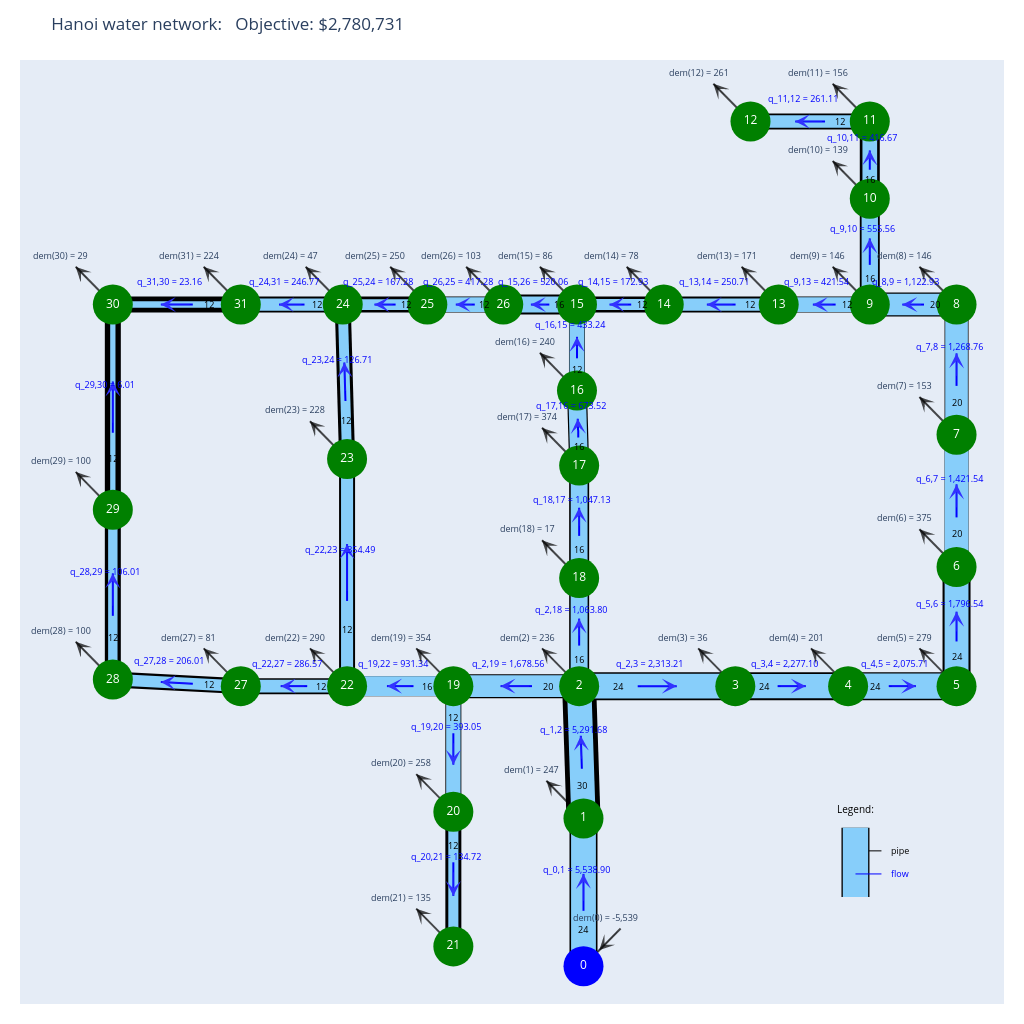

In [11]:
print_results(model_1, network_1)

create_flow_graph_with_model(model_1, network_1)

## References

* "An MINLP Solution Method for a Water Network Problem" - C. Bragalli, C. D'Ambrosio, J. Lee, A. Lodi, P. Toth (2006) [DOI](https://doi.org/10.1007/11841036_62)
* "Mathematical programming techniques in water network optimization" - C. D’Ambrosio, A., S. Wiese, C. Bragalli (2015) [DOI](https://doi.org/10.1016/j.ejor.2014.12.039)
* "Design of Optimal Water Distribution System" - E. Alperovits and U. Shamir (1977) [DOI](https://doi.org/10.1029/WR013i006p00885)
* "A two-phase decomposition method for optimal design of looped water distribution networks" - Okitsugu Fujiwara, Do Ba Khang (1990) [DOI](https://doi.org/10.1029/WR026i004p00539)